In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import textworld
from textworld.utils import uniquify
from collections import Counter
import itertools

from textworld.challenges.cooking import FOODS

In [4]:
for f in FOODS:
    print(f)

egg
milk
water
vegetable oil
peanut oil
olive oil
chicken wing
chicken leg
chicken breast
pork chop
red tuna
white tuna
carrot
red onion
white onion
yellow onion
lettuce
red potato
yellow potato
purple potato
red apple
yellow apple
green apple
banana
tomato
red hot pepper
green hot pepper
red bell pepper
yellow bell pepper
green bell pepper
orange bell pepper
black pepper
flour
salt
sugar
block of cheese
cilantro
parsley


In [6]:
def split(dataset, ratio, rng=None):
    rng = rng or np.random.RandomState(42)
    dataset = list(dataset)
    rng.shuffle(dataset)
    train_size = int(ratio * len(dataset))
    if len(dataset) == 1:
        train_size = int(rng.rand() > 0.5)
        
    train = dataset[:train_size]
    valid = dataset[train_size::2]
    test = dataset[train_size+1::2]
    print("{} => {} | {} | {}".format(len(dataset), len(train), len(valid), len(test)))
    assert len(dataset) == len(train) + len(valid) + len(test)
    return train, valid, test


In [7]:
from collections import Counter

def prepare_dataset(ratio, rng):
    # Extract all food names
    
    one_words = [f for f in FOODS if len(f.split()) == 1]
    suffixes = [f.split()[-1] for f in FOODS if len(f.split()) > 1]
    prefixes = [f.split()[0] for f in FOODS if len(f.split()) > 1]

    print(Counter(prefixes))
    print(Counter(suffixes))

    # Split frequent prefixes
    frequent_prefixes = [prefix for prefix, count in Counter(prefixes).items() if count > 1]
    frequent_suffixes = [suffix for suffix, count in Counter(suffixes).items() if count > 1]
    infrequent_prefixes = [prefix for prefix, count in Counter(prefixes).items() if count == 1]
    infrequent_suffixes = [suffix for suffix, count in Counter(suffixes).items() if count == 1]

    print(frequent_prefixes)
    print(frequent_suffixes)


    ratio = 0.6
    train, valid, test = [], [], []
    _train, _valid, _test = split(frequent_prefixes, ratio, rng)
    train += _train
    valid += _valid
    test += _test

    _train, _valid, _test = split(frequent_suffixes, ratio, rng)
    train += _train
    valid += _valid
    test += _test

    _train, _valid, _test = split(infrequent_prefixes, ratio, rng)
    train += _train
    valid += _valid
    test += _test

    _train, _valid, _test = split(infrequent_suffixes, ratio, rng)
    train += _train
    valid += _valid
    test += _test

    _train, _valid, _test = split(one_words, ratio, rng)
    train += _train
    valid += _valid
    test += _test

    print(train)
    print(valid)
    print(test)
    assert len(set(train) & set(valid) & set(test)) == 0
    train = [f for f in FOODS if len(set(f.split()) & set(train)) > 0]
    valid = [f for f in FOODS if len(set(f.split()) & set(valid)) > 0]
    test = [f for f in FOODS if len(set(f.split()) & set(test)) > 0]
    
    print(train)
    print(valid)
    print(test)
    assert len(FOODS) == len(set(train) | set(valid) | set(test))
    
    return train, valid, test


0.6 22478
38 => 22 | 8 | 8


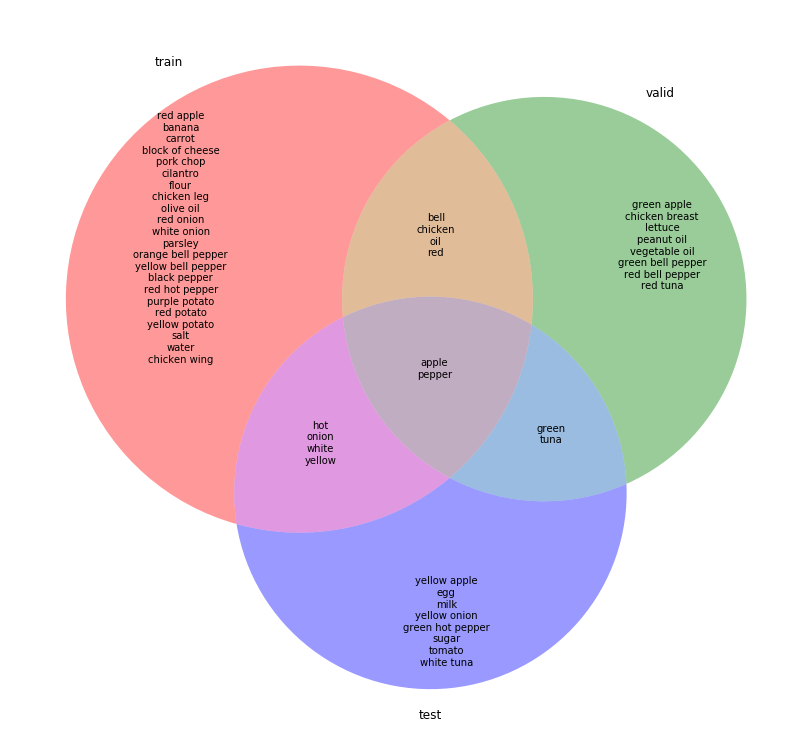

In [10]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def split_dataset(dataset, ratio, seed=None):
    seed = seed or np.random.randint(65635)
    rng = np.random.RandomState(seed)
    # (0.4, 2901)
    # (0.6 38671)
    print(ratio, seed)

    train, valid, test = split(dataset, ratio=ratio, rng=rng)

    def _get_words(dataset):
        return set(w for f in dataset for w in f.split())


    def build_formatter_fct():
        cpt = [0]
        def _fct(arg=None):
            if cpt[0] == 0:
                assert  len(train) == len(set(train) - set(valid) - set(test))
                words = train
            elif cpt[0] == 1:
                assert len(valid) == len(set(valid) - set(train) - set(test))
                words = valid
            elif cpt[0] == 2:
                words = (_get_words(train) & _get_words(valid)) - _get_words(test)
            elif cpt[0] == 3:
                assert len(test) == len(set(test) - set(valid) - set(train))
                words = test
            elif cpt[0] == 4:
                words = (_get_words(test) & _get_words(train)) - _get_words(valid)
            elif cpt[0] == 5:
                words = (_get_words(test) & _get_words(valid)) - _get_words(train)
            elif cpt[0] == 6:
                words = _get_words(train) & _get_words(valid) & _get_words(test)
            else:
                return None

            cpt[0] += 1
            return "\n".join(sorted(words, key=lambda s: s.split()[::-1]))
            #return "\n".join(textwrap.wrap(" ".join(words), width=20))

        return _fct

    fct = build_formatter_fct()
    subsets = [fct() for _ in range(7)]
    sizes = [len(subset)**0.5 for subset in subsets]

    plt.figure(figsize=(16*1.5,9*1.5))
    venn = venn3(sizes, ("train", "valid", "test"), subset_label_formatter=build_formatter_fct())
    plt.show()
    return train, valid, test

train, valid, test = split_dataset(FOODS, ratio=0.6, seed=22478)

In [11]:
print("Nb. foods: {}".format(len(FOODS)))

Nb. foods: 38


{'banana': [('grilled', 'uncut'),
            ('grilled', 'chopped'),
            ('grilled', 'sliced'),
            ('grilled', 'diced'),
            ('fried', 'uncut'),
            ('fried', 'chopped'),
            ('fried', 'sliced'),
            ('fried', 'diced'),
            ('roasted', 'uncut'),
            ('roasted', 'chopped'),
            ('roasted', 'sliced'),
            ('roasted', 'diced'),
            ('raw', 'uncut'),
            ('raw', 'chopped'),
            ('raw', 'sliced'),
            ('raw', 'diced')],
 'black pepper': [('raw', 'uncut')],
 'block of cheese': [('grilled', 'uncut'),
                     ('grilled', 'chopped'),
                     ('grilled', 'sliced'),
                     ('grilled', 'diced'),
                     ('fried', 'uncut'),
                     ('fried', 'chopped'),
                     ('fried', 'sliced'),
                     ('fried', 'diced'),
                     ('roasted', 'uncut'),
                     ('roasted', 'chopped'),


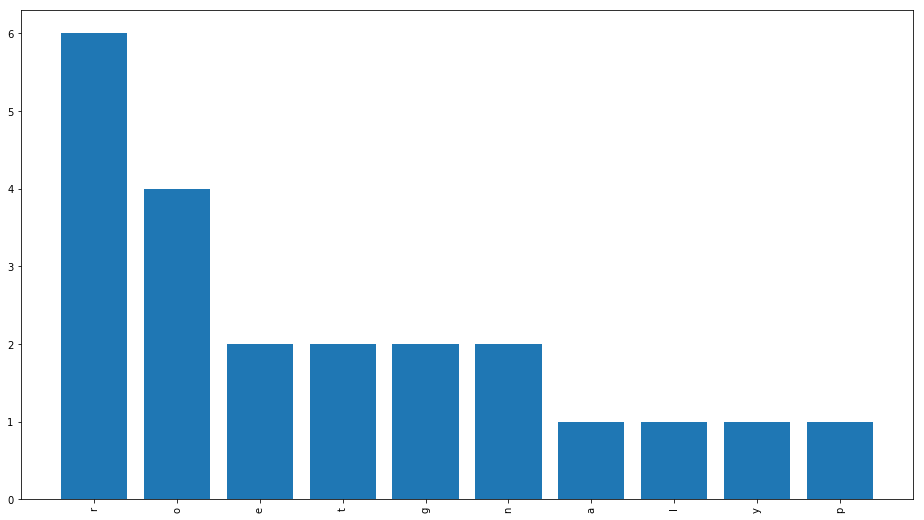

In [29]:
import itertools

def get_food_preparations(foods):
    food_preparations = {}
    for f in foods:
        v = FOODS[f]
        cookings = ["raw"]
        if "cookable" in v["properties"]:
            cookings = ["grilled", "fried", "roasted"]
            if "needs_cooking" not in v["properties"]:
                cookings.append("raw")
        
        cuttings = ["uncut"]
        if "cuttable" in v["properties"]:
            cuttings = ["uncut", "chopped", "sliced", "diced"]

        food_preparations[f] = list(itertools.product(cookings, cuttings))
        
    return food_preparations

def get_processed_foods(foods):
    processed_foods = get_food_preparations(foods)
    processed_foods_text = [" ".join(preparation + (f,)) for f, preparations in processed_foods.items()
                            for preparation in preparations]

    lengths = list(map(len, processed_foods_text))
    print("\n".join([text.rjust(max(lengths)) for text in sorted(processed_foods_text, key=lambda s: s.split()[::-1])]))

    from collections import defaultdict
    counts = defaultdict(int)
    for f in processed_foods:
        counts[f[-1]] += 1

    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,9))
    labels, data = zip(*sorted(counts.items(), key=lambda e: e[1], reverse=True))
    plt.bar(labels, data)
    plt.xticks(labels, rotation='vertical')
    plt.show()
    return processed_foods, processed_foods_text
    
processed_foods, processed_foods_text = get_processed_foods(train)

In [13]:
processed_foods

[('grilled', 'uncut', 'orange bell pepper'),
 ('grilled', 'chopped', 'orange bell pepper'),
 ('grilled', 'sliced', 'orange bell pepper'),
 ('grilled', 'diced', 'orange bell pepper'),
 ('fried', 'uncut', 'orange bell pepper'),
 ('fried', 'chopped', 'orange bell pepper'),
 ('fried', 'sliced', 'orange bell pepper'),
 ('fried', 'diced', 'orange bell pepper'),
 ('roasted', 'uncut', 'orange bell pepper'),
 ('roasted', 'chopped', 'orange bell pepper'),
 ('roasted', 'sliced', 'orange bell pepper'),
 ('roasted', 'diced', 'orange bell pepper'),
 ('raw', 'uncut', 'orange bell pepper'),
 ('raw', 'chopped', 'orange bell pepper'),
 ('raw', 'sliced', 'orange bell pepper'),
 ('raw', 'diced', 'orange bell pepper'),
 ('grilled', 'uncut', 'block of cheese'),
 ('grilled', 'chopped', 'block of cheese'),
 ('grilled', 'sliced', 'block of cheese'),
 ('grilled', 'diced', 'block of cheese'),
 ('fried', 'uncut', 'block of cheese'),
 ('fried', 'chopped', 'block of cheese'),
 ('fried', 'sliced', 'block of cheese')

In [26]:
from collections import defaultdict
def split_food_processings(processed_foods, ratio, seed):
    seed = seed or rng.random.randint(65363)
    rng = np.random.RandomState(seed)
    
    tmp = defaultdict(list)
    for processing in processed_foods:
        tmp[processing[-1]].append(processing[:-1])

    train, valid, test = defaultdict(list), defaultdict(list), defaultdict(list)
    for k, v in tmp.items(): 
        _train, _valid, _test = split(v, ratio=ratio, rng=rng)
        train[k] += _train
        valid[k] += _valid
        test[k] += _test

    return {"train": dict(train), "valid": dict(valid), "test": dict(test)}

foods_preparations = split_food_processings(processed_foods, ratio=0.6, seed=1234)
foods_preparations

16 => 9 | 4 | 3
16 => 9 | 4 | 3
1 => 0 | 1 | 0
16 => 9 | 4 | 3
16 => 9 | 4 | 3
16 => 9 | 4 | 3
1 => 0 | 1 | 0
3 => 1 | 1 | 1
4 => 2 | 1 | 1
16 => 9 | 4 | 3
12 => 7 | 3 | 2
1 => 1 | 0 | 0
1 => 1 | 0 | 0
16 => 9 | 4 | 3
12 => 7 | 3 | 2
4 => 2 | 1 | 1
12 => 7 | 3 | 2
1 => 0 | 1 | 0
12 => 7 | 3 | 2
16 => 9 | 4 | 3
3 => 1 | 1 | 1
16 => 9 | 4 | 3


{'train': {'orange bell pepper': [('raw', 'chopped'),
   ('roasted', 'diced'),
   ('grilled', 'uncut'),
   ('raw', 'uncut'),
   ('raw', 'sliced'),
   ('grilled', 'sliced'),
   ('roasted', 'sliced'),
   ('fried', 'diced'),
   ('grilled', 'chopped')],
  'block of cheese': [('fried', 'diced'),
   ('fried', 'uncut'),
   ('grilled', 'chopped'),
   ('raw', 'chopped'),
   ('grilled', 'diced'),
   ('roasted', 'chopped'),
   ('grilled', 'sliced'),
   ('raw', 'uncut'),
   ('raw', 'sliced')],
  'black pepper': [],
  'red hot pepper': [('roasted', 'sliced'),
   ('fried', 'chopped'),
   ('roasted', 'uncut'),
   ('fried', 'sliced'),
   ('raw', 'sliced'),
   ('grilled', 'chopped'),
   ('fried', 'uncut'),
   ('raw', 'chopped'),
   ('grilled', 'sliced')],
  'yellow bell pepper': [('roasted', 'chopped'),
   ('grilled', 'sliced'),
   ('fried', 'sliced'),
   ('raw', 'diced'),
   ('roasted', 'diced'),
   ('fried', 'chopped'),
   ('roasted', 'uncut'),
   ('grilled', 'uncut'),
   ('fried', 'uncut')],
  'bana

# OLD

In [111]:
def _intersect(set1, set2):
    result = set()
    for e1 in set1:
        for e2 in set2:
            if len(set(e1.split()) & set(e2.split())) > 0:
                result.add(e1)
                result.add(e2)
    
    return result


def _substract(set1, set2):
    result = set()
    for e1 in set1:
        found = True
        for e2 in set2:
            if len(set(e1.split()) & set(e2.split())) > 0:
                found = False
                break
        
        if found:
            result.add(e1)
    
    return result


print(_intersect(["green pepper", "red pepper"], ["green onion", "yellow apple"]))

print(_substract(["green pepper", "red pepper"], ["green onion", "yellow apple"]))

{'green pepper', 'green onion'}
{'red pepper'}


In [ ]:
import textwrap
import numpy as np
from matplotlib_venn import venn3

#train, valid, test = split(FOODS, ratio=0.6)
train, valid, test = prepare_dataset(ratio=0.6, rng=np.random.RandomState(421))

def _get_words(dataset):
    return set(w for f in dataset for w in f.split())


def build_formatter_fct():
    cpt = [0]
    def _fct(arg=None):
        """
        if cpt[0] == 0:
            words = _get_words(train) - _get_words(valid) - _get_words(test)
        elif cpt[0] == 1:
            words = _get_words(valid) - _get_words(train) - _get_words(test)
        elif cpt[0] == 2:
            words = (_get_words(valid) & _get_words(train)) - _get_words(test)
        elif cpt[0] == 3:
            words = _get_words(test) - _get_words(train) - _get_words(valid)
        elif cpt[0] == 4:
            words = (_get_words(test) & _get_words(train)) - _get_words(valid)
        elif cpt[0] == 5:
            words = (_get_words(test) & _get_words(valid)) - _get_words(train)
        elif cpt[0] == 6:
            words = _get_words(test) & _get_words(valid) & _get_words(train)
        else:
            return None
        """
        if cpt[0] == 0:
            words = _substract(_substract(train, valid), test)
        elif cpt[0] == 1:
            words = _substract(_substract(valid, train), test)
        elif cpt[0] == 2:
            words = _substract(_intersect(train, valid), test)
        elif cpt[0] == 3:
            words = _substract(_substract(test, valid), train)
        elif cpt[0] == 4:
            words = _substract(_intersect(train, test), valid)
        elif cpt[0] == 5:
            words = _substract(_intersect(valid, test), train)
        elif cpt[0] == 6:
            words = _intersect(_intersect(train, valid), test)
        else:
            return None

        cpt[0] += 1
        return "\n".join(words)
        #return "\n".join(textwrap.wrap(" ".join(words), width=20))
    
    return _fct


def build_formatter_fct_old():
    cpt = [0]
    def _fct(arg=None):
        if cpt[0] == 0:
            words = _substract(_substract(train, valid), test)
        elif cpt[0] == 1:
            words = _substract(_substract(valid, train), test)
        elif cpt[0] == 2:
            words = _substract(_intersect(train, valid), test)
        elif cpt[0] == 3:
            words = _substract(_substract(test, valid), train)            
        elif cpt[0] == 4:
            words = _substract(_intersect(train, test), valid)
        elif cpt[0] == 5:
            words = _substract(_intersect(valid, test), train)
        elif cpt[0] == 6:
            words = _intersect(_intersect(train, valid), test)
        else:
            return None

        cpt[0] += 1
        return "\n".join(words)
        #return "\n".join(textwrap.wrap(" ".join(words), width=20))
    
    return _fct


def build_simple_formatter_fct():
    cpt = [0]
    def _fct(arg=None):
        if cpt[0] == 0:
            words = set(train) - set(valid) - set(test)
        elif cpt[0] == 1:
            words = set(valid) - set(train) - set(test)
        elif cpt[0] == 2:
            words = (set(train) & set(valid)) - set(test)
        elif cpt[0] == 3:
            words = set(test) - set(valid) - set(train)
        elif cpt[0] == 4:
            words = (set(train) & set(test)) - set(valid)
        elif cpt[0] == 5:
            words = (set(test) & set(valid)) - set(train)
        elif cpt[0] == 6:
            words = set(train) & set(valid) & set(test)
        else:
            return None

        cpt[0] += 1
        print(words)
        return "\n".join(words)
        #return "\n".join(textwrap.wrap(" ".join(words), width=20))
    
    return _fct



fct = build_formatter_fct()
subsets = [fct() for _ in range(7)]
sizes = [len(subset)**0.5 for subset in subsets]
    
plt.figure(figsize=(16*1.5,9*1.5))
#venn = venn3((_get_words(train), _get_words(valid), _get_words(test)), ("train", "valid", "test"),
#      subset_label_formatter=build_formatter_fct(), normalize_to=100.)
venn = venn3(sizes, ("train", "valid", "test"), subset_label_formatter=build_formatter_fct())
plt.show()

38


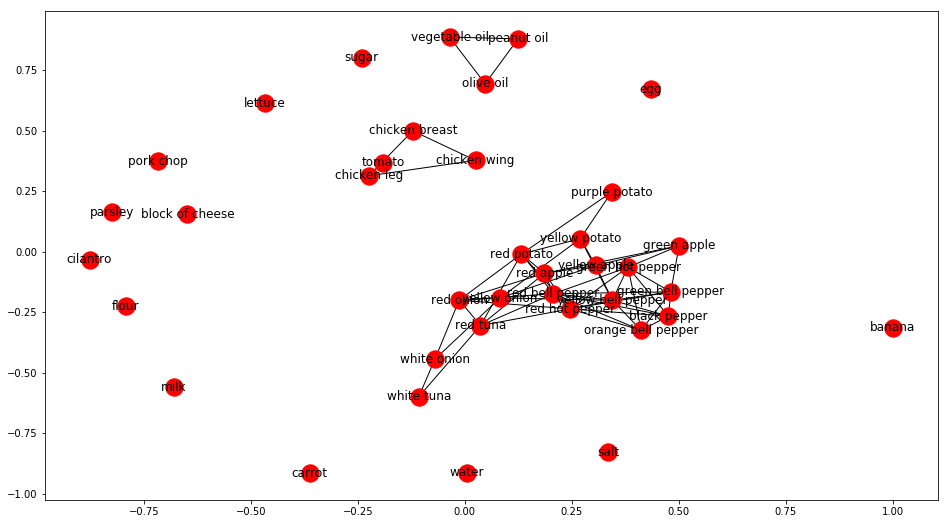

In [45]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()
#G.add_nodes_from(FOODS.keys())

for food in FOODS:
    G.add_node(food)
    for node in G.nodes:
        if node == food:
            continue
            
        if len(set(food.split()) & set(node.split())) > 0:
            G.add_edge(food, node)

plt.figure(figsize=(16,9))
pos = nx.spring_layout(G, iterations=10)
nx.draw_networkx(G, pos=pos)
print(len(G))
plt.show()